In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cufflinks as cf
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
%matplotlib inline
sns.set_style('whitegrid')
warnings.filterwarnings("ignore")


In [2]:
#file directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
#import data train
data_train = pd.read_csv('../HousePrices/train.csv')
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#check data train total rows and columns
print('Data Train rows:', data_train.shape[0])
print('Data Train columns:', data_train.shape[1])

Data Train rows: 1460
Data Train columns: 81


In [6]:
#check data train columns and its types
print('Data Train columns:\n')
print(data_train.dtypes)

Data Train columns:

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


In [8]:
#import data test
data_test = pd.read_csv('../HousePrices/test.csv')
data_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [9]:
#check data test rows and columns
print('Data Test rows:', data_test.shape[0])
print('Data Test columns:', data_test.shape[1])

Data Test rows: 1459
Data Test columns: 80


# Sale Price Data Analysis

In [10]:
data_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [11]:
#sale price histogram
cf.go_offline()
data_train['SalePrice'].iplot(kind='hist',bins=30,color='blue')

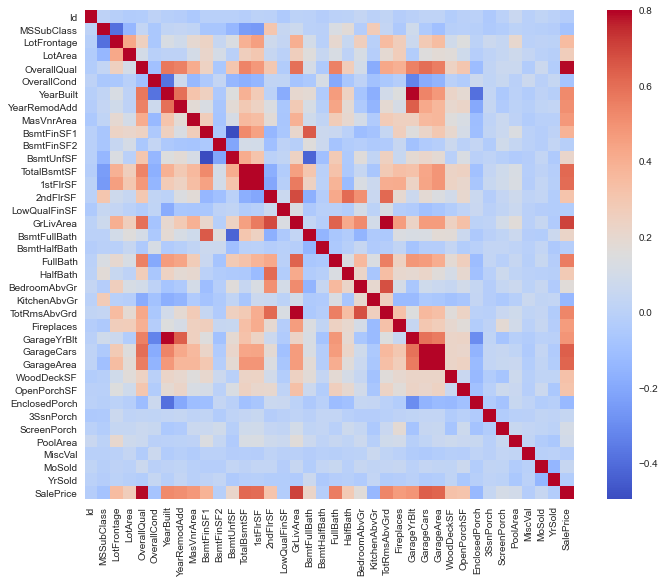

In [12]:
#correlation matrix heatmap
corrmat = data_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap='coolwarm', vmax=.8, square=True);

In [13]:
#correlation matrix numbers
data_train.corr().style.background_gradient(cmap='coolwarm').set_precision(4)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.0000,0.0112,-0.0106,-0.0332,-0.0284,0.0126,-0.0127,-0.0220,-0.0503,-0.0050,-0.0060,-0.0079,-0.0154,0.0105,0.0056,-0.0442,0.0083,0.0023,-0.0202,0.0056,0.0068,0.0377,0.0030,0.0272,-0.0198,0.0001,0.0166,0.0176,-0.0296,-0.0005,0.0029,-0.0466,0.0013,0.0570,-0.0062,0.0212,0.0007,-0.0219
MSSubClass,0.0112,1.0000,-0.3863,-0.1398,0.0326,-0.0593,0.0279,0.0406,0.0229,-0.0698,-0.0656,-0.1408,-0.2385,-0.2518,0.3079,0.0465,0.0749,0.0035,-0.0023,0.1316,0.1774,-0.0234,0.2817,0.0404,-0.0456,0.0851,-0.0401,-0.0987,-0.0126,-0.0061,-0.0120,-0.0438,-0.0260,0.0083,-0.0077,-0.0136,-0.0214,-0.0843
LotFrontage,-0.0106,-0.3863,1.0000,0.4261,0.2516,-0.0592,0.1233,0.0889,0.1935,0.2336,0.0499,0.1326,0.3921,0.4572,0.0802,0.0385,0.4028,0.1009,-0.0072,0.1988,0.0535,0.2632,-0.0061,0.3521,0.2666,0.0702,0.2857,0.3450,0.0885,0.1520,0.0107,0.0700,0.0414,0.2062,0.0034,0.0112,0.0074,0.3518
LotArea,-0.0332,-0.1398,0.4261,1.0000,0.1058,-0.0056,0.0142,0.0138,0.1042,0.2141,0.1112,-0.0026,0.2608,0.2995,0.0510,0.0048,0.2631,0.1582,0.0480,0.1260,0.0143,0.1197,-0.0178,0.1900,0.2714,-0.0249,0.1549,0.1804,0.1717,0.0848,-0.0183,0.0204,0.0432,0.0777,0.0381,0.0012,-0.0143,0.2638
OverallQual,-0.0284,0.0326,0.2516,0.1058,1.0000,-0.0919,0.5723,0.5507,0.4119,0.2397,-0.0591,0.3082,0.5378,0.4762,0.2955,-0.0304,0.5930,0.1111,-0.0402,0.5506,0.2735,0.1017,-0.1839,0.4275,0.3968,0.5478,0.6007,0.5620,0.2389,0.3088,-0.1139,0.0304,0.0649,0.0652,-0.0314,0.0708,-0.0273,0.7910
OverallCond,0.0126,-0.0593,-0.0592,-0.0056,-0.0919,1.0000,-0.3760,0.0737,-0.1281,-0.0462,0.0402,-0.1368,-0.1711,-0.1442,0.0289,0.0255,-0.0797,-0.0549,0.1178,-0.1941,-0.0608,0.0130,-0.0870,-0.0576,-0.0238,-0.3243,-0.1858,-0.1515,-0.0033,-0.0326,0.0704,0.0255,0.0548,-0.0020,0.0688,-0.0035,0.0439,-0.0779
YearBuilt,-0.0127,0.0279,0.1233,0.0142,0.5723,-0.3760,1.0000,0.5929,0.3157,0.2495,-0.0491,0.1490,0.3915,0.2820,0.0103,-0.1838,0.1990,0.1876,-0.0382,0.4683,0.2427,-0.0707,-0.1748,0.0956,0.1477,0.8257,0.5379,0.4790,0.2249,0.1887,-0.3873,0.0314,-0.0504,0.0049,-0.0344,0.0124,-0.0136,0.5229
YearRemodAdd,-0.0220,0.0406,0.0889,0.0138,0.5507,0.0737,0.5929,1.0000,0.1796,0.1285,-0.0678,0.1811,0.2911,0.2404,0.1400,-0.0624,0.2874,0.1195,-0.0123,0.4390,0.1833,-0.0406,-0.1496,0.1917,0.1126,0.6423,0.4206,0.3716,0.2057,0.2263,-0.1939,0.0453,-0.0387,0.0058,-0.0103,0.0215,0.0357,0.5071
MasVnrArea,-0.0503,0.0229,0.1935,0.1042,0.4119,-0.1281,0.3157,0.1796,1.0000,0.2647,-0.0723,0.1144,0.3639,0.3445,0.1746,-0.0691,0.3909,0.0853,0.0267,0.2768,0.2014,0.1028,-0.0376,0.2807,0.2491,0.2527,0.3642,0.3731,0.1597,0.1257,-0.1102,0.0188,0.0615,0.0117,-0.0298,-0.0060,-0.0082,0.4775
BsmtFinSF1,-0.0050,-0.0698,0.2336,0.2141,0.2397,-0.0462,0.2495,0.1285,0.2647,1.0000,-0.0501,-0.4953,0.5224,0.4459,-0.1371,-0.0645,0.2082,0.6492,0.0674,0.0585,0.0043,-0.1074,-0.0810,0.0443,0.2600,0.1535,0.2241,0.2970,0.2043,0.1118,-0.1023,0.0265,0.0620,0.1405,0.0036,-0.0157,0.0144,0.3864


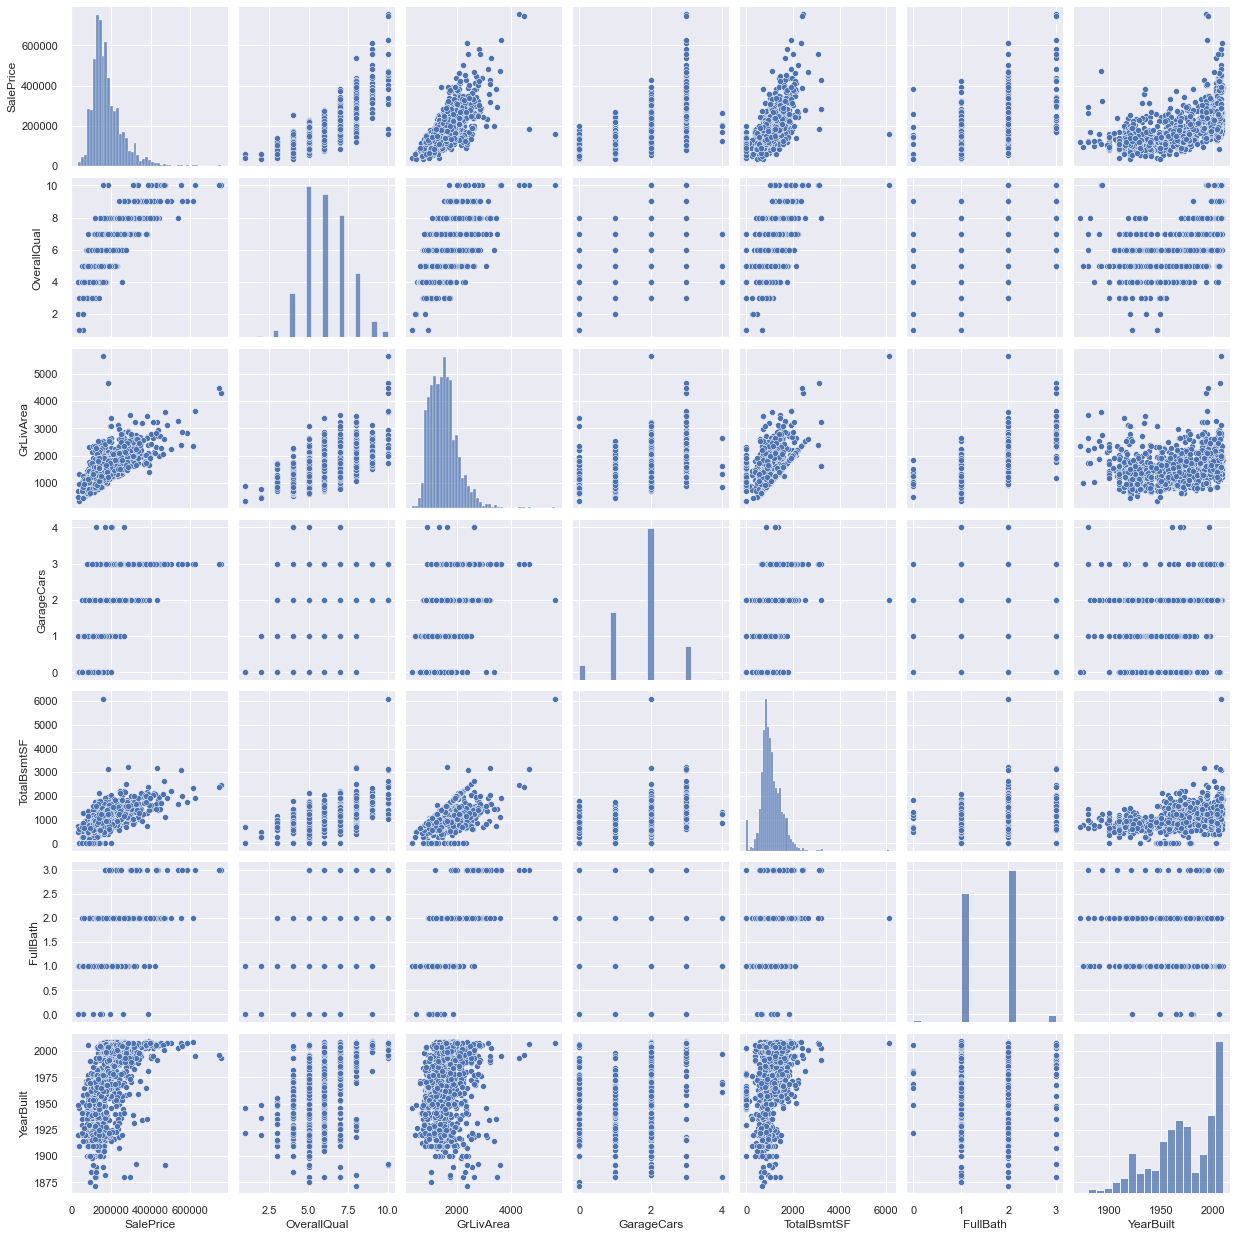

In [14]:
#histogram and scatter plot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(data_train[cols], height = 2.5)
plt.show();

# Imputing Missing Data

<AxesSubplot:>

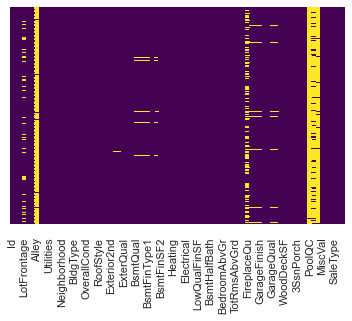

In [15]:
#missing data train heatmap
sns.heatmap(data_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot:>

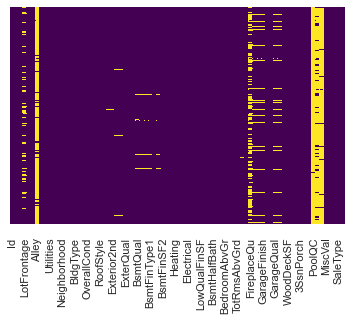

In [16]:
#missing data test heatmap
sns.heatmap(data_test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [17]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(data_train.shape))
print("The test data size before dropping Id feature is : {} ".format(data_test.shape))

#Save the 'Id' column
data_train_ID = data_train['Id']
data_test_ID = data_test['Id']

#Now drop the 'Id' column since it's unnecessary for the prediction process.
new_data_train = data_train.copy()
new_data_test = data_test.copy()
new_data_train.drop("Id", axis = 1, inplace = True)
new_data_test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(new_data_train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(new_data_test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


In [18]:
price = new_data_train['SalePrice']

In [19]:
#combine data train and data test
ntrain = new_data_train.shape[0]
ntest = new_data_test.shape[0]
all_data = pd.concat((new_data_train, new_data_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [20]:
#check ratio of null values
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageYrBlt,5.447071
GarageQual,5.447071
GarageCond,5.447071


Text(0.5, 1.0, 'Percent missing data by feature')

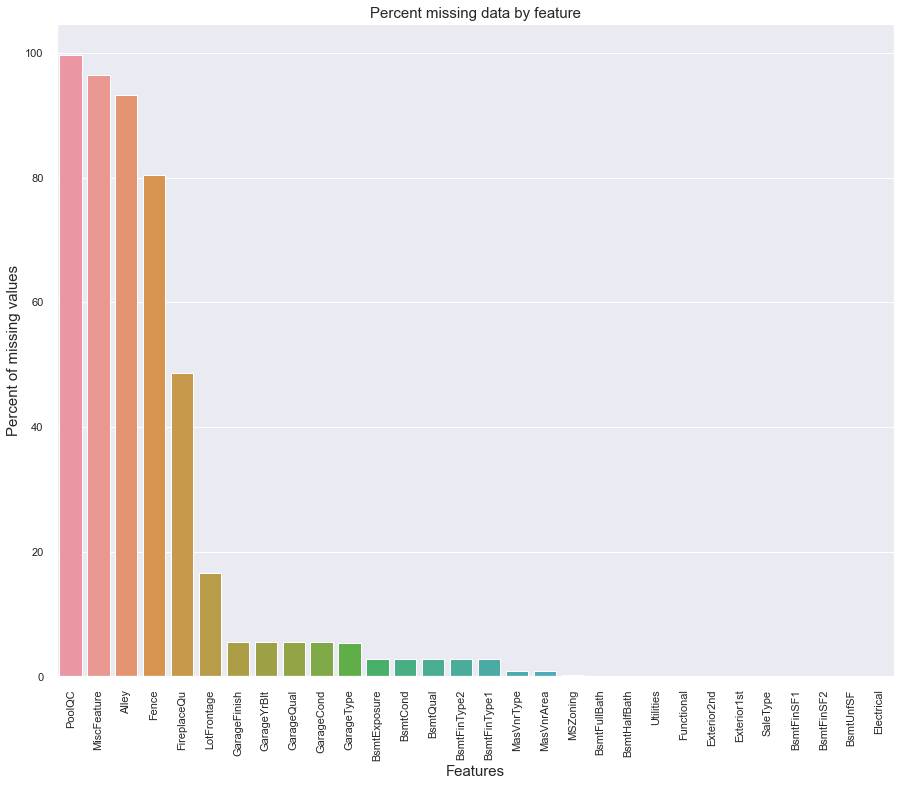

In [21]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [22]:
all_data[['GarageType','GarageYrBlt', 'GarageFinish', 'GarageArea', 'GarageQual','GarageCond']].head(len(all_data[['GarageType','GarageYrBlt', 'GarageFinish', 'GarageArea', 'GarageQual','GarageCond']]))

,GarageType,GarageYrBlt,GarageFinish,GarageArea,GarageQual,GarageCond
0,Attchd,2003.0,RFn,548.0,TA,TA
1,Attchd,1976.0,RFn,460.0,TA,TA
2,Attchd,2001.0,RFn,608.0,TA,TA
3,Detchd,1998.0,Unf,642.0,TA,TA
4,Attchd,2000.0,RFn,836.0,TA,TA
...,...,...,...,...,...,...
2914,NaN,NaN,NaN,0.0,NaN,NaN
2915,CarPort,1970.0,Unf,286.0,TA,TA
2916,Detchd,1960.0,Unf,576.0,TA,TA
2917,NaN,NaN,NaN,0.0,NaN,NaN


In [23]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [24]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [25]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [26]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [27]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [28]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

<AxesSubplot:>

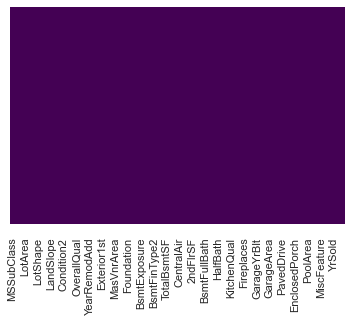

In [29]:
sns.heatmap(all_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# Model Creation

In [30]:
#create dummy variables
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 300)


In [31]:
clean_data_train = all_data[:ntrain]
clean_data_test = all_data[ntrain:]

In [32]:
#remove outliers
z = np.abs(stats.zscore(clean_data_train.select_dtypes(['int64','float64'])))
no_outliers_data_train = clean_data_train[(z < 3).all(axis=1)]
no_outliers_price = price[(z < 3).all(axis=1)]

print(no_outliers_data_train.shape)
print(no_outliers_price.shape)

(975, 300)
(975,)


In [33]:
#split data train
X_train, X_test, y_train, y_test = train_test_split(no_outliers_data_train, no_outliers_price, test_size = 0.1)

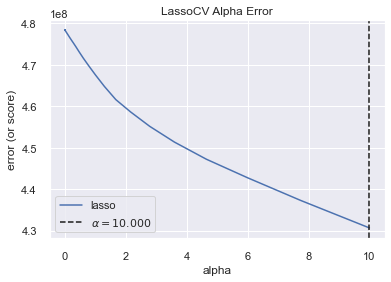

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [34]:
#Lasso regression model fitting

# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 100)

# Instantiate the linear model and visualizer
model_lasso = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model_lasso)
visualizer.fit(X_train, y_train)
visualizer.show()

In [35]:
#Lasso regression's score
print('Score:', model_lasso.score(X_train,y_train))

#RMSE
pred_in_train_lasso = model_lasso.predict(X_train)
pred_out_train_lasso = model_lasso.predict(X_test)
rmse_in_train_lasso = mean_squared_error(y_train, pred_in_train_lasso, squared=False)
rmse_out_train_lasso = mean_squared_error(y_test, pred_out_train_lasso, squared=False)

print('RMSE in Train:', rmse_in_train_lasso)
print('RMSE outside Train:', rmse_out_train_lasso)

Score: 0.9458740780026168
RMSE in Train: 15292.365386927311
RMSE outside Train: 20586.4581354943


In [36]:
#XGBoost regression model fitting
model_xgboost = XGBRegressor(random_state=0)
model_xgboost.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
#XGBoost regression's score
print('Score:', model_xgboost.score(X_train,y_train))

#RMSE
pred_in_train_xgboost = model_xgboost.predict(X_train)
pred_out_train_xgboost = model_xgboost.predict(X_test)
rmse_in_train_xgboost = mean_squared_error(y_train, pred_in_train_xgboost, squared=False)
rmse_out_train_xgboost = mean_squared_error(y_test, pred_out_train_xgboost, squared=False)

print('RMSE in Train:', rmse_in_train_xgboost)
print('RMSE outside Train:', rmse_out_train_xgboost)

Score: 0.999811839773675
RMSE in Train: 901.6457210172603
RMSE outside Train: 22062.04426208813


In [38]:
#create all lasso models
from sklearn.linear_model import Lasso

all_lasso_models = []

for i in alphas:
    all_lasso_models.append(Lasso(i).fit(X_train,y_train))

In [39]:
#RMSE
pred_in_train_lasso_combination = 0
pred_out_train_lasso_combination = 0
n = len(all_lasso_models)

for i in all_lasso_models:
    pred_in_train_lasso_combination += 1/n*i.predict(X_train)
    pred_out_train_lasso_combination += 1/n*i.predict(X_test)

rmse_in_train_lasso_combination = mean_squared_error(y_train, pred_in_train_lasso_combination, squared=False)
rmse_out_train_lasso_combination = mean_squared_error(y_test, pred_out_train_lasso_combination, squared=False)

print('RMSE in Train:', rmse_in_train_lasso_combination)
print('RMSE outside Train:', rmse_out_train_lasso_combination)

RMSE in Train: 15129.752881980032
RMSE outside Train: 21880.112250586015


Meta-Classifier

In [40]:
#predict the lasso combination results
def meta_classifiers_transformation(independent_variables):
    all_lasso_combination_results = []

    for i in all_lasso_models:
        all_lasso_combination_results.append(i.predict(independent_variables))

    all_lasso_combination_results = pd.DataFrame(all_lasso_combination_results).T
    
    return(all_lasso_combination_results)

In [41]:
#create the model
model_lasso_xgboost = XGBRegressor(random_state=0)
model_lasso_xgboost.fit(meta_classifiers_transformation(X_train),y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
#Meta-Classifier's score
print('Score:', model_lasso_xgboost.score(meta_classifiers_transformation(X_train),y_train))

#RMSE
pred_in_train_lasso_xgboost = model_lasso_xgboost.predict(meta_classifiers_transformation(X_train))
pred_out_train_lasso_xgboost = model_lasso_xgboost.predict(meta_classifiers_transformation(X_test))
rmse_in_train_lasso_xgboost = mean_squared_error(y_train, pred_in_train_lasso_xgboost, squared=False)
rmse_out_train_lasso_xgboost = mean_squared_error(y_test, pred_out_train_lasso_xgboost, squared=False)

print('RMSE in Train:', rmse_in_train_lasso_xgboost)
print('RMSE outside Train:', rmse_out_train_lasso_xgboost)

Score: 0.9953530249686027
RMSE in Train: 4480.816739209792
RMSE outside Train: 22187.084032043316


# Prediction

In [43]:
#prediction of Lasso regression
final_pred = 0

for i in all_lasso_models:
    final_pred += 1/n*i.predict(clean_data_test)

#create data frame
df = {
    'Id' : data_test_ID,
    'SalePrice' : final_pred
}

df = pd.DataFrame(df)

df.to_csv('Output.csv', index = False)

df

,Id,SalePrice
0,1461,134986.548812
1,1462,371968.093296
2,1463,193727.718821
3,1464,201301.216448
4,1465,211122.451813
...,...,...
1454,2915,178457.964501
1455,2916,95369.634018
1456,2917,184981.620768
1457,2918,217717.555739
